>### Reference
- https://keras.io/examples/vision/edsr/
- Deep learning with Python 2nd
- 빵형 Youtube

>### imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image
import cv2, os, glob
from skimage.transform import pyramid_expand
from skimage.transform import pyramid_reduce 

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('dark_background')    

import warnings
warnings.filterwarnings(action='ignore')

def fn_makedirs(path): 
   try: 
        os.makedirs(path) 
   except OSError: 
       if not os.path.isdir(path): 
           raise

>### 데이터 전처리(preprocessing)
- 1) 데이터는 네트워크에 주입되기 전에 부동 소수점 타입의 텐서로 적절하게 전처리
- 2) 사진 피일을 읽는다.
- 3) JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
- 4) 그 다음, 부동 소수점 타입의 텐서로 변환
- 5) 동일한 크기의 이미지로 변경
- 6) 배치로 묶는다.

>### Download / load the training dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 39s 0us/step


In [4]:
print('data_dir:', data_dir, type(data_dir))

data_dir: C:\Users\sel04327\.keras\datasets\flower_photos <class 'pathlib.WindowsPath'>


>### directory 구조
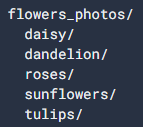

>### data의 갯수 확인

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_list = list(data_dir.glob('*/*.jpg'))
print(image_count)
print(image_list[:3])

3670
[WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg')]


>### 데이터 출력

C:\Users\sel04327\.keras\datasets\flower_photos\roses\10090824183_d02c613f10_m.jpg
roses count: 641


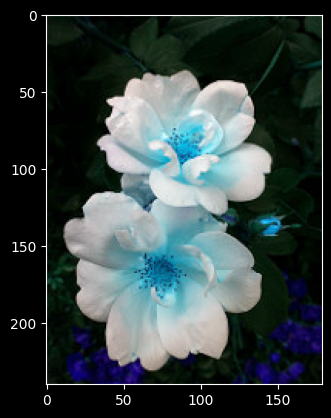

In [6]:
roses = list(data_dir.glob('roses/*'))
print(roses[0])

roses_cnt = len(roses)
print('roses count:', roses_cnt)

img_sample = cv2.imread(os.path.join(roses[0]))
plt.imshow(img_sample)

In [18]:
print('sample의 형태: ', img_sample.shape)

shape_list = []
for idx, image in enumerate(image_list):
    _ = cv2.imread(os.path.join(image))
    shape_list.append(_.shape)

print('image_list 중, 최소사이즈:', min(shape_list))

sample의 형태:  (240, 179, 3)
image_list 중, 최소사이즈: (159, 240, 3)


>### Sample 데이터 check
- Crop / DownScale 통해, Low / High resolution(input/target) 만들기

240 179
0 1


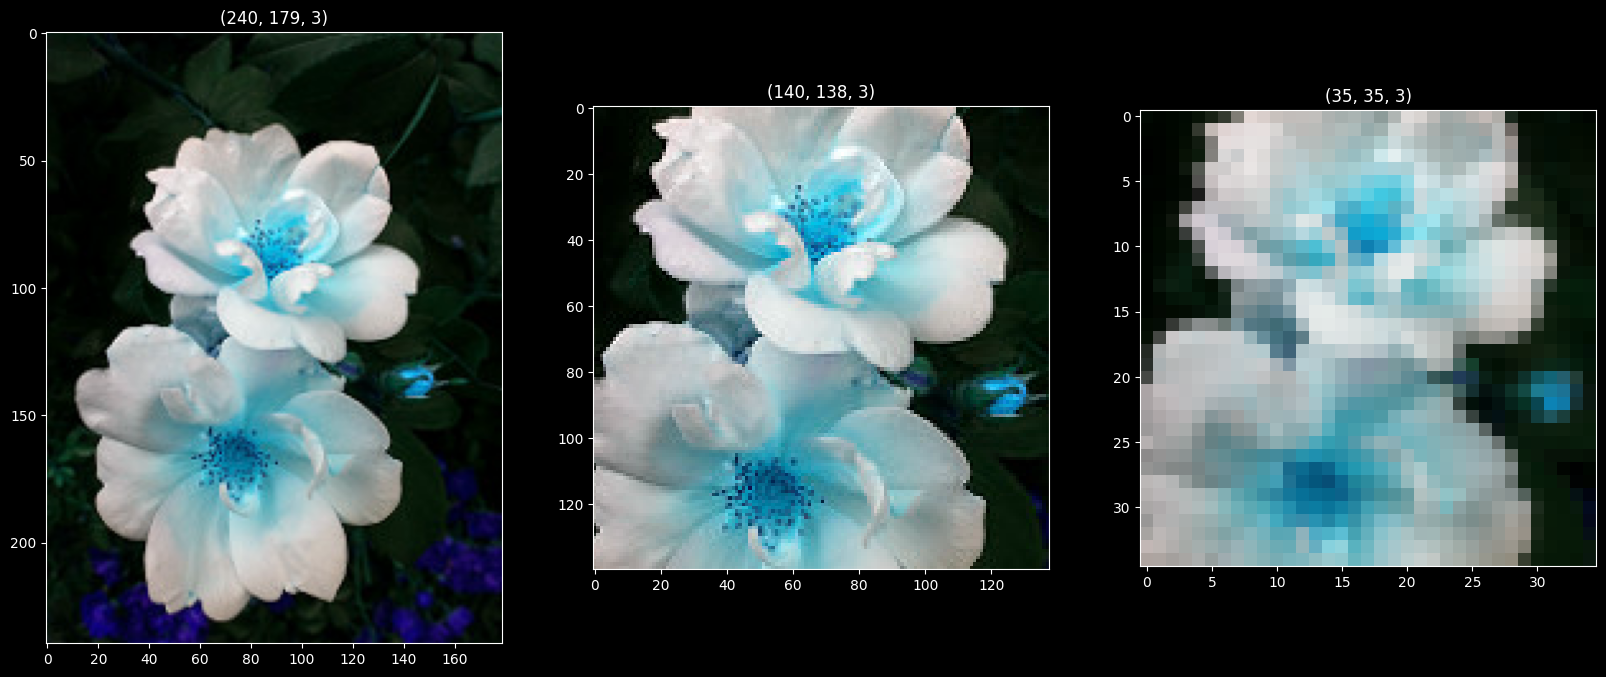

In [26]:
import matplotlib.pyplot as plt

h, w, _ = img_sample.shape
print(h, w)

## 홀수일 경우, 정확히 정사각형 image shape이 같아지지 않는 경우를 prevent
odd_h = 0
odd_w = 0
if h % 2 == 1:
    odd_h = 1
if w % 2 == 1:
    odd_w = 1

wnt_size = 140

print(odd_h, odd_w)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.title(img_sample.shape)
plt.imshow(img_sample)

## 정사각형으로 이미지 자르기
crop_sample = img_sample[round((h-wnt_size)/2)+odd_h:round(-(h-wnt_size)/2), round((w-wnt_size)/2)+odd_w:round(-(w-wnt_size)/2), :]
plt.subplot(1, 3, 2)
plt.title(crop_sample.shape)
plt.imshow(crop_sample)

## 정사각형 이미지를 pyramid_reduce를 통해서 downscale한다.
from skimage.transform import pyramid_reduce
down_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
plt.subplot(1, 3, 3)
plt.title(down_sample.shape)
plt.imshow(down_sample)